<a href="https://colab.research.google.com/github/bcdmodelos/qualificacao-modelscode/blob/main/Modelo-GPR/codigo_modelo_gpr_campina_grande.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Análise por Regressão por Processos Gaussianos para a cidade de Campina Grande

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, DotProduct, Matern

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
%cd /content/drive/MyDrive/Notebooks_Doutorado/base-campina/

!ls

/content/drive/MyDrive/Notebooks_Doutorado/base-campina
dataset_Amazonas_usableData.csv
dataset_Bodocongo_usable.csv
dataset_Brasil_usableData.csv
dataset_CampinaGrande_casos_acumulados_usable.csv
dataset_CampinaGrande_casos_diarios_usable.csv
dataset_CampinaGrande_usableData.csv
dataset_Catole_usable.csv
dataset_Malvinas_usable.csv
dataset_Paraiba_usableData.csv
dataset_Pernambuco_usableData.csv


In [9]:
file_path = "./dataset_CampinaGrande_casos_acumulados_usable.csv"
casosCampinaGrande = pd.read_csv(file_path, encoding='latin1')
casosCampinaGrande

,Data,cum_casos
0,22/03/2020,25
1,23/03/2020,26
2,26/03/2020,27
3,27/03/2020,28
4,03/04/2020,29
...,...,...
448,27/06/2021,26542
449,28/06/2021,26580
450,29/06/2021,26600
451,30/06/2021,26633


In [10]:
dfCampinaGrande  = casosCampinaGrande

# Visualização do Dataset de número de casos acumulados

Text(0.5, 0, 'Dia')

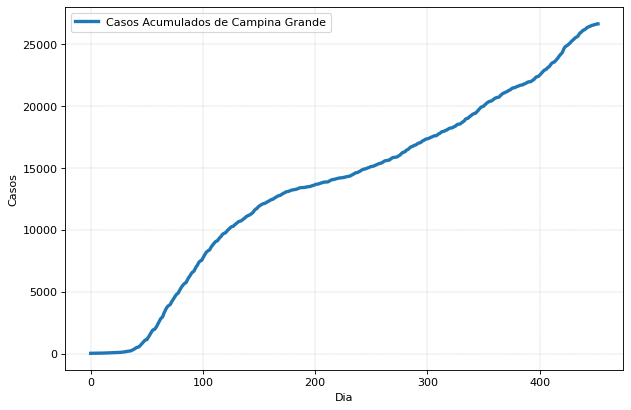

In [12]:
data = np.array(dfCampinaGrande.cum_casos.values)
data = data.reshape(-1, 1)

CRdata = data/1000
CRdata  = np.ravel(CRdata)

plt.figure(2, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data, linewidth = 3)
plt.legend(['Casos Acumulados de Campina Grande'])
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos')
plt.xlabel('Dia')

Dataset de teste

In [13]:
trainL = len(CRdata) - 30

t = np.linspace(1,len(CRdata),len(CRdata))
t = t.reshape(len(t),1)
t = np.atleast_2d(t)

t_tr  = t[0:trainL]
t_test = t[trainL:]

CR_tr = CRdata[0:trainL]
CR_test = CRdata[trainL:]

In [14]:
def half_data(data, time):
    half_data = []
    half_time = []
    for i,item in enumerate(data):
        if i%2 == 0:
            half_data.append(item)
            half_time.append(time[i])

    return np.array(half_data), np.array(half_time)

Modelagem

In [15]:
def GPR_Model(CR_tr, t_tr, CR_test, t_test):

    t = np.append(t_tr, t_test).reshape(-1,1)
    CRdata = np.append(CR_tr, CR_test)

    #kernel = ConstantKernel()* Matern(1.0)*RBF() + DotProduct()
    kernel = ConstantKernel()*RBF()*DotProduct(sigma_0 = 0)*ConstantKernel(constant_value= 0.005)
    # kernel = RBF()
    # kernel = Matern()

    model  = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha = 10, normalize_y=False)

    model.fit(t_tr, CR_tr)
    print("\nLearned kernel: %s" % model.kernel_)
    params = model.kernel_.get_params()

    R2_tr  = model.score(t_tr, CR_tr)
    R2     = model.score(t, CRdata)
    R2_test = model.score(t_test, CR_test)

    CRpred_tr, sigma_tr = model.predict(t_tr, return_std=True)
    CRpred_test, sigma_test = model.predict(t_test, return_std=True)
    CRpred, sigma   = model.predict(t, return_std=True)

    MSE = np.mean(((CRpred_tr-CR_tr)*1000)**2)
    print("\nMSE: %f" % MSE)
    print("\nSTD: %f" % np.sqrt(MSE))
    print("\nR2 treinamento: %f" % R2_tr)
    print("\nR2 todo intervalo de dados: %f" % R2)
    print("\nR2 de teste: %f" % R2_test)

    return CRpred_tr, sigma_tr, CRpred_test, sigma_test, CRpred, sigma, t, CRdata

In [16]:
CRpred_tr, sigma_tr, CRpred_test, sigma_test, CRpred, sigma, t, CRdata = GPR_Model(CR_tr, t_tr, CR_test, t_test)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 0.149**2 * RBF(length_scale=120) * DotProduct(sigma_0=4.07) * 0.375**2

MSE: 82370.840154

STD: 287.003206

R2 treinamento: 0.998311

R2 todo intervalo de dados: 0.997213

R2 de teste: -2.318436


In [24]:
def plot_gpr(CRdata, CRpred, sigma, t):
    plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
    mpl.style.use('default')
    plt.plot(t, CRdata*1000, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados Campina Grande')
    plt.axvline(x = t_test[0],linestyle= '--', color = 'black')
    plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR', linewidth = 3)
    plt.fill(np.concatenate([t, t[::-1]]),
            np.concatenate([CRpred*1000 - 1.96000 * 1000*sigma,
                            (CRpred*1000 + 1.96000 * 1000*sigma)[::-1]]),
            alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
    plt.legend(loc='upper left', fontsize = 14)
    plt.grid(color='k', linestyle='--', linewidth=0.1)
    plt.ylabel('Total de casos', fontsize = 14)
    plt.xlabel('dia', fontsize = 14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

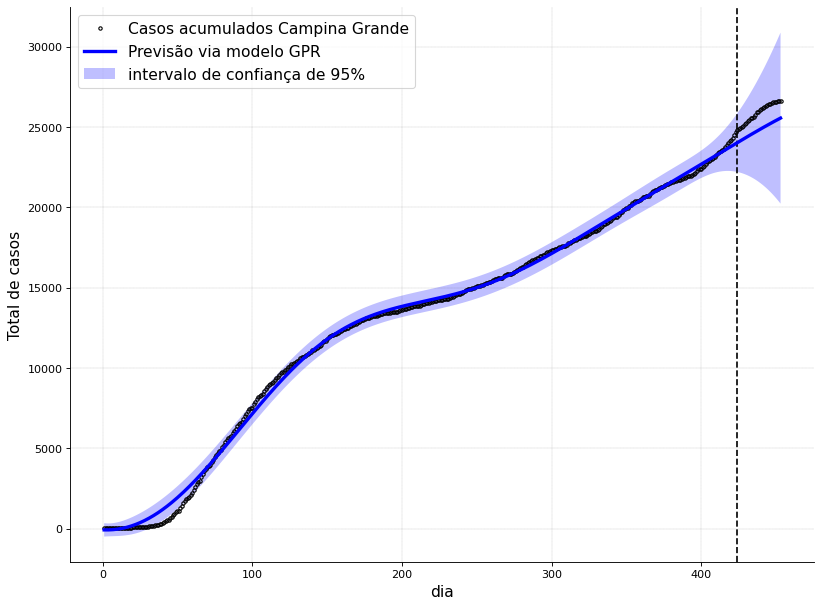

In [25]:
plot_gpr(CRdata, CRpred, sigma, t)

Análise para 50% dos dados

In [26]:
CR_tr_half,t_tr_half = half_data(CR_tr, t_tr)

In [27]:
CRpred_tr_half, sigma_tr_half, CRpred_test_half, sigma_test_half, CRpred_half, sigma_half, t_half, CRdata_half = GPR_Model(CR_tr_half, t_tr_half, CR_test, t_test)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 0.0413**2 * RBF(length_scale=151) * DotProduct(sigma_0=18.8) * 1.25**2

MSE: 215042.672084

STD: 463.726937

R2 treinamento: 0.995613

R2 todo intervalo de dados: 0.990300

R2 de teste: -8.110263


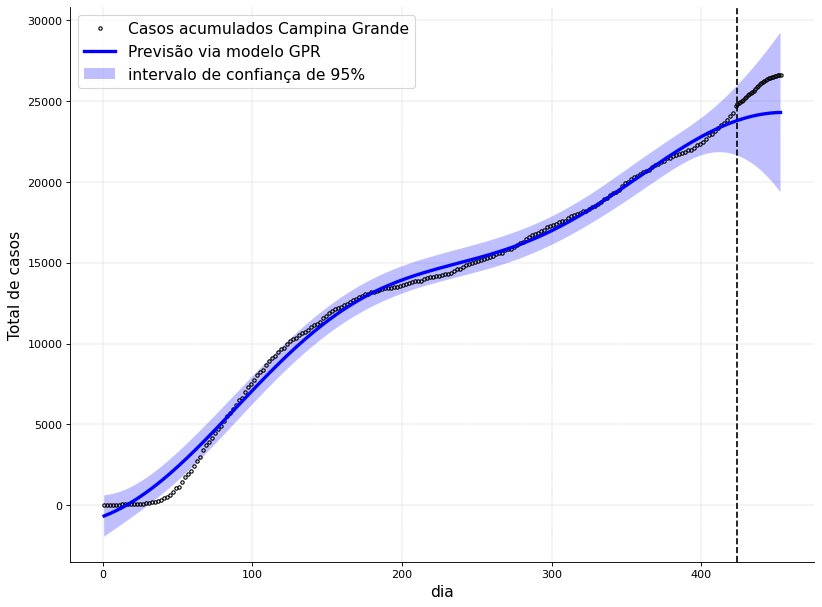

In [28]:
plot_gpr(CRdata_half, CRpred_half, sigma_half, t_half)

Análise para 1/4 dos dados

In [29]:
CR_tr_quarter,t_tr_quarter = half_data(CR_tr_half, t_tr_half)
CRpred_tr_quarter, sigma_tr_quarter, CRpred_test_quarter, sigma_test_quarter, CRpred_quarter, sigma_quarter, t_quarter, CRdata_quarter = GPR_Model(CR_tr_quarter, t_tr_quarter, CR_test, t_test)


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 0.103**2 * RBF(length_scale=1.43e+03) * DotProduct(sigma_0=1.37e-05) * 0.635**2

MSE: 1266301.647879

STD: 1125.300692

R2 treinamento: 0.974178

R2 todo intervalo de dados: 0.966460

R2 de teste: -15.177286


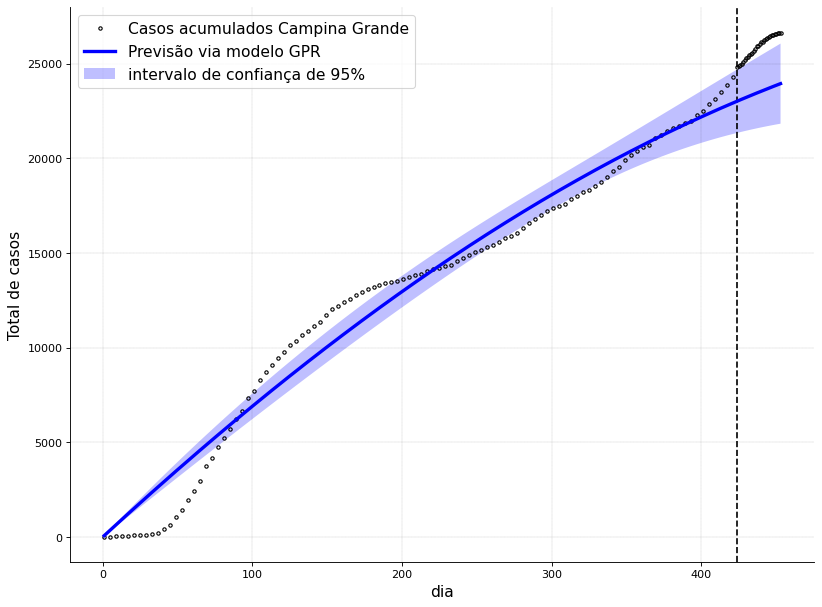

In [30]:
plot_gpr(CRdata_quarter, CRpred_quarter, sigma_quarter, t_quarter)